In [1]:
import gc # garbage collector
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

BATCH_SIZE = 32
EPOCHS = 10
ADD_NOM = "4_b" + str(BATCH_SIZE) + "_e" + str(EPOCHS)

In [3]:
# shape of the image : 50x50
# number of classes : 62 (26 letters majuscules, 26 letters minuscules, 10 chiffres)

# Dataset_v1 / Dataset_v2
# total of images : 798_402
# number of train images : 487_227
# number of test images : 155_489
# number of validation images : 155_686

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données
collection = db["Dataset_v2"]  # Nom de la collection

In [5]:
def fetch_data(repartition: str, nbr: int):
    query = {"Repartition": repartition}
    documents = collection.find(query)
    print(f"fetch {repartition} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            types.append(doc["Type"])
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

In [6]:
# Récupération des données d'entraînement
df_train = fetch_data("train", 487_227)
df_train = df_train.sample(frac=1).reset_index(drop=True) # shuffle
print(df_train.shape)
df_train.head()
# Temps : 53.6s

fetch train OK !!!


Proccessing: 100%|██████████| 487227/487227 [00:53<00:00, 9118.04it/s] 


(487227, 3)


,Labels,Types,Images
0,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,l,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,B,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
# Récupération des données de test
df_test = fetch_data("test", 155_489)
df_test = df_test.sample(frac=1).reset_index(drop=True) # shuffle
print(df_test.shape)
df_test.head()
# Temps : 7.9s

fetch test OK !!!


Proccessing: 100%|██████████| 155489/155489 [00:07<00:00, 19692.77it/s]


(155489, 3)


,Labels,Types,Images
0,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# Récupération des données de validation
df_validation = fetch_data("validation", 155_686)
df_validation = df_validation.sample(frac=1).reset_index(drop=True) # shuffle
print(df_validation.shape)
df_validation.head()
# Temps : 7.2s

fetch validation OK !!!


Proccessing: 100%|██████████| 155686/155686 [00:07<00:00, 21776.47it/s]

(155686, 3)


,Labels,Types,Images
0,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Données pour apprentissage du NN 'Get types'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get type' qui permettra de classé les images selon trois catégories :

- Majuscule
- Minuscule
- Nombre

In [9]:
X_train_types = np.array(df_train["Images"].tolist())
y_train_types = np.array(df_train["Types"].tolist())
X_test_types = np.array(df_test["Images"].tolist())
y_test_types = np.array(df_test["Types"].tolist())
X_validation_types = np.array(df_validation["Images"].tolist())
y_validation_types = np.array(df_validation["Types"].tolist())
# Temps : 

In [10]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_types = LabelEncoder()

y_train_types_2 = label_encoder_types.fit_transform(y_train_types)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_types_2 = label_encoder_types.transform(y_test_types)
y_validation_types_2 = label_encoder_types.transform(y_validation_types)

In [11]:
# Correspondance indices ↔ labels
correspondance_types = dict(enumerate(label_encoder_types.classes_))
print(correspondance_types)

# Liste des labels
labels_types = list(correspondance_types.values())
print(labels_types)

{0: 'Maj', 1: 'Min', 2: 'Nbr'}
['Maj', 'Min', 'Nbr']


In [12]:
# Afficher quelques informations
print(f"Taille de X_train_types: {X_train_types.shape}, y_train_types: {y_train_types.shape}, y_train_types_2: {y_train_types_2.shape}")
print(f"Taille de X_test_types: {X_test_types.shape}, y_test_types: {y_test_types.shape}, y_test_types_2: {y_test_types_2.shape}")
print(f"Taille de X_validation_types: {X_validation_types.shape}, y_validation_types: {y_validation_types.shape}, y_validation_types_2: {y_validation_types_2.shape}")

Taille de X_train_types: (487227, 625), y_train_types: (487227,), y_train_types_2: (487227,)
Taille de X_test_types: (155489, 625), y_test_types: (155489,), y_test_types_2: (155489,)
Taille de X_validation_types: (155686, 625), y_validation_types: (155686,), y_validation_types_2: (155686,)


### Données pour apprentissage du NN 'Get Maj'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Maj' qui permettra de classé les images selon la lettre majuscule qui y est representée.

In [54]:
df_train_Maj = df_train[df_train["Types"] == "Maj"]
print(df_train_Maj.shape) # (, 3)
df_train_Maj.head()
# Temps : 

(150341, 3)


,Labels,Types,Images
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,B,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11,J,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [55]:
df_test_Maj = df_test[df_test["Types"] == "Maj"]
print(df_test_Maj.shape) # (, 3)
df_test_Maj.head()
# Temps :

(43121, 3)


,Labels,Types,Images
5,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,E,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,B,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14,S,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,L,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [56]:
df_validation_Maj = df_validation[df_validation["Types"] == "Maj"]
print(df_validation_Maj.shape) # (, 3)
df_validation_Maj.head()
# Temps :

(43250, 3)


,Labels,Types,Images
6,J,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,D,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,L,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,V,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [57]:
X_train_Maj = np.array(df_train_Maj["Images"].tolist())
y_train_Maj = np.array(df_train_Maj["Labels"].tolist())
X_test_Maj = np.array(df_test_Maj["Images"].tolist())
y_test_Maj = np.array(df_test_Maj["Labels"].tolist())
X_validation_Maj = np.array(df_validation_Maj["Images"].tolist())
y_validation_Maj = np.array(df_validation_Maj["Labels"].tolist())
# Temps : 

In [58]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Maj = LabelEncoder()

y_train_Maj_2 = label_encoder_Maj.fit_transform(y_train_Maj)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Maj_2 = label_encoder_Maj.transform(y_test_Maj)
y_validation_Maj_2 = label_encoder_Maj.transform(y_validation_Maj)

In [59]:
# Correspondance indices ↔ labels
correspondance_Maj = dict(enumerate(label_encoder_Maj.classes_))
print(correspondance_Maj)

# Liste des labels
labels_Maj = list(correspondance_Maj.values())
print(labels_Maj)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [60]:
# Afficher quelques informations
print(f"Taille de X_train_Maj: {X_train_Maj.shape}, y_train_Maj: {y_train_Maj.shape}, y_train_Maj_2: {y_train_Maj_2.shape}")
print(f"Taille de X_test_Maj: {X_test_Maj.shape}, y_test_Maj: {y_test_Maj.shape}, y_test_Maj_2: {y_test_Maj_2.shape}")
print(f"Taille de X_validation_Maj: {X_validation_Maj.shape}, y_validation_Maj: {y_validation_Maj.shape}, y_validation_Maj_2: {y_validation_Maj_2.shape}")

Taille de X_train_Maj: (150341, 625), y_train_Maj: (150341,), y_train_Maj_2: (150341,)
Taille de X_test_Maj: (43121, 625), y_test_Maj: (43121,), y_test_Maj_2: (43121,)
Taille de X_validation_Maj: (43250, 625), y_validation_Maj: (43250,), y_validation_Maj_2: (43250,)


### Données pour apprentissage du NN 'Get Min'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Min' qui permettra de classé les images selon la lettre minuscule qui y est representée.

In [61]:
df_train_Min = df_train[df_train["Types"] == "Min"]
print(df_train_Min.shape) # (, 3)
df_train_Min.head()
# Temps : 

(111713, 3)


,Labels,Types,Images
2,l,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,h,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,i,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,l,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [62]:
df_test_Min = df_test[df_test["Types"] == "Min"]
print(df_test_Min.shape) # (, 3)
df_test_Min.head()
# Temps :

(37358, 3)


,Labels,Types,Images
10,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,n,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [63]:
df_validation_Min = df_validation[df_validation["Types"] == "Min"]
print(df_validation_Min.shape) # (, 3)
df_validation_Min.head()
# Temps :

(37374, 3)


,Labels,Types,Images
12,l,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14,d,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30,y,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [64]:
X_train_Min = np.array(df_train_Min["Images"].tolist())
y_train_Min = np.array(df_train_Min["Labels"].tolist())
X_test_Min = np.array(df_test_Min["Images"].tolist())
y_test_Min = np.array(df_test_Min["Labels"].tolist())
X_validation_Min = np.array(df_validation_Min["Images"].tolist())
y_validation_Min = np.array(df_validation_Min["Labels"].tolist())
# Temps : 5m 21.2s

In [65]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Min = LabelEncoder()

y_train_Min_2 = label_encoder_Min.fit_transform(y_train_Min)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Min_2 = label_encoder_Min.transform(y_test_Min)
y_validation_Min_2 = label_encoder_Min.transform(y_validation_Min)

In [66]:
# Correspondance indices ↔ labels
correspondance_Min = dict(enumerate(label_encoder_Min.classes_))
print(correspondance_Min)

# Liste des labels
labels_Min = list(correspondance_Min.values())
print(labels_Min)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [67]:
# Afficher quelques informations
print(f"Taille de X_train_Min: {X_train_Min.shape}, y_train_Min: {y_train_Min.shape}, y_train_Min_2: {y_train_Min_2.shape}")
print(f"Taille de X_test_Min: {X_test_Min.shape}, y_test_Min: {y_test_Min.shape}, y_test_Min_2: {y_test_Min_2.shape}")
print(f"Taille de X_validation_Min: {X_validation_Min.shape}, y_validation_Min: {y_validation_Min.shape}, y_validation_Min_2: {y_validation_Min_2.shape}")

Taille de X_train_Min: (111713, 625), y_train_Min: (111713,), y_train_Min_2: (111713,)
Taille de X_test_Min: (37358, 625), y_test_Min: (37358,), y_test_Min_2: (37358,)
Taille de X_validation_Min: (37374, 625), y_validation_Min: (37374,), y_validation_Min_2: (37374,)


### Données pour apprentissage du NN 'Get Nbr'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Nbr' qui permettra de classé les images selon le chiffre qui y est représenté.

In [68]:
df_train_Nbr = df_train[df_train["Types"] == "Nbr"]
print(df_train_Nbr.shape) # (, 3)
df_train_Nbr.head()
# Temps : 

(225173, 3)


,Labels,Types,Images
0,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [69]:
df_test_Nbr = df_test[df_test["Types"] == "Nbr"]
print(df_test_Nbr.shape) # (, 3)
df_test_Nbr.head()
# Temps : 

(75010, 3)


,Labels,Types,Images
0,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [70]:
df_validation_Nbr = df_validation[df_validation["Types"] == "Nbr"]
print(df_validation_Nbr.shape) # (, 3)
df_validation_Nbr.head()
# Temps : 

(75062, 3)


,Labels,Types,Images
0,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [71]:
X_train_Nbr = np.array(df_train_Nbr["Images"].tolist())
y_train_Nbr = np.array(df_train_Nbr["Labels"].tolist())
X_test_Nbr = np.array(df_test_Nbr["Images"].tolist())
y_test_Nbr = np.array(df_test_Nbr["Labels"].tolist())
X_validation_Nbr = np.array(df_validation_Nbr["Images"].tolist())
y_validation_Nbr = np.array(df_validation_Nbr["Labels"].tolist())
# Temps : 8m 30.5s

In [72]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Nbr = LabelEncoder()

y_train_Nbr_2 = label_encoder_Nbr.fit_transform(y_train_Nbr)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Nbr_2 = label_encoder_Nbr.transform(y_test_Nbr)
y_validation_Nbr_2 = label_encoder_Nbr.transform(y_validation_Nbr)

In [73]:
# Correspondance indices ↔ labels
correspondance_Nbr = dict(enumerate(label_encoder_Nbr.classes_))
print(correspondance_Nbr)

# Liste des labels
labels_Nbr = list(correspondance_Nbr.values())
print(labels_Nbr)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [74]:
# Afficher quelques informations
print(f"Taille de X_train_Nbr: {X_train_Nbr.shape}, y_train_Nbr: {y_train_Nbr.shape}, y_train_Nbr_2: {y_train_Nbr_2.shape}")
print(f"Taille de X_test_Nbr: {X_test_Nbr.shape}, y_test_Nbr: {y_test_Nbr.shape}, y_test_Nbr_2: {y_test_Nbr_2.shape}")
print(f"Taille de X_validation_Nbr: {X_validation_Nbr.shape}, y_validation_Nbr: {y_validation_Nbr.shape}, y_validation_Nbr_2: {y_validation_Nbr_2.shape}")

Taille de X_train_Nbr: (225173, 625), y_train_Nbr: (225173,), y_train_Nbr_2: (225173,)
Taille de X_test_Nbr: (75010, 625), y_test_Nbr: (75010,), y_test_Nbr_2: (75010,)
Taille de X_validation_Nbr: (75062, 625), y_validation_Nbr: (75062,), y_validation_Nbr_2: (75062,)


# Get Type (NN)
---

Modèle ...

In [75]:
# Reseau de neurones
model_get_type = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 625 neurones (25x25 pixels)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='sigmoid') # output layer : 3 neurones (Maj, Min, Nbr) -> softmax : sortie à 3 classes
])

model_get_type.compile(
    optimizer='adam', # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
)

In [76]:
model_get_type.fit(
    X_train_types, 
    y_train_types_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_types, 
        y_validation_types_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.8618
# loss : 0.3311
# Temps : 16m 33.5s

# Batch 64
# accuracy : 0.8644
# loss : 0.3228
# Temps : 8m 41s

# Batch 128
# accuracy : 0.8654
# loss : 0.3209
# Temps : 4m 35.4s

# Batch 256
# accuracy : 0.8644
# loss : 0.3220
# Temps : 2m 46.5s

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.7740 - loss: 0.5328 - val_accuracy: 0.8184 - val_loss: 0.4387
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.8311 - loss: 0.4066 - val_accuracy: 0.8260 - val_loss: 0.4203
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.8412 - loss: 0.3822 - val_accuracy: 0.8337 - val_loss: 0.4014
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.8471 - loss: 0.3675 - val_accuracy: 0.8388 - val_loss: 0.3896
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.8512 - loss: 0.3572 - val_accuracy: 0.8380 - val_loss: 0.3932
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.8542 - loss: 0.3495 - val_accuracy: 0.8409 - val_loss: 0.3894
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.8573 - loss: 0.3430 - val_accuracy: 0.8393 - val_loss: 0.3938
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 

In [77]:
test_loss_type, test_acc_type = model_get_type.evaluate(X_test_types, y_test_types_2)
print(f"Test accuracy : {test_acc_type}") # Test accuracy : 
print(f"Test loss : {test_loss_type}") # Test loss : 
# Temps : 8.3s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - accuracy: 0.8423 - loss: 0.4281
Test accuracy : 0.8435773849487305
Test loss : 0.40888503193855286


In [78]:
# Sauvegarder le modèle
model_get_type.save("../models/Get_type_v" + ADD_NOM + ".keras")  # Format HDF5 (.h5)

In [79]:
y_predicted_types = model_get_type.predict(X_test_types)
y_predicted_types[1]
# Temps : 7.2s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 4s 761us/step


array([0.9999933, 0.9994471, 1.       ], dtype=float32)

In [80]:
np.argmax(y_predicted_types[1])

2

In [81]:
# y_predicted_labels1 = np.array([correspondance_types[np.argmax(i)] for i in y_predicted_types])
y_predicted_labels_types = [np.argmax(i) for i in y_predicted_types]
y_predicted_labels_types[:5]

[2, 2, 0, 2, 2]

In [82]:
y_test_types_2[:5]

array([2, 2, 2, 2, 2])

Text(95.72222222222221, 0.5, 'Truth')

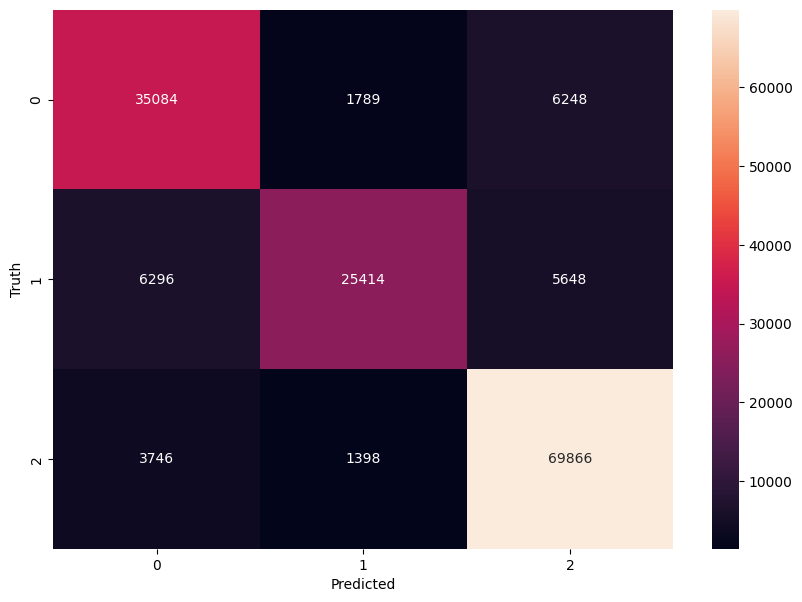

In [83]:
# Matrice de confusion
cm_types = tf.math.confusion_matrix(labels=y_test_types_2, predictions=y_predicted_labels_types)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_types, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Maj (NN)
---

Modèle ...

In [84]:
model_get_maj = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_maj.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [85]:
model_get_maj.fit(
    X_train_Maj, 
    y_train_Maj_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_Maj, 
        y_validation_Maj_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9508
# loss : 0.1701
# Temps : 5m 17.7s

# Batch 64
# accuracy : 0.9522
# loss : 0.1632
# Temps : 2m 18.6s

# Batch 128
# accuracy : 0.9558
# loss : 0.1531
# Temps : 1m 19.8s

# Batch 256
# accuracy : 0.9527
# loss : 0.1621
# Temps : 51.7s

Epoch 1/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8053 - loss: 0.7012 - val_accuracy: 0.9152 - val_loss: 0.3154
Epoch 2/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9201 - loss: 0.2890 - val_accuracy: 0.9224 - val_loss: 0.2925
Epoch 3/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9314 - loss: 0.2480 - val_accuracy: 0.9293 - val_loss: 0.2728
Epoch 4/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9368 - loss: 0.2250 - val_accuracy: 0.9306 - val_loss: 0.2676
Epoch 5/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9405 - loss: 0.2102 - val_accuracy: 0.9301 - val_loss: 0.2736
Epoch 6/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9433 - loss: 0.1972 - val_accuracy: 0.9317 - val_loss: 0.2712
Epoch 7/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9444 - loss: 0.1936 - val_accuracy: 0.9308 - val_loss: 0.2770
Epoch 8/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9471 - loss: 0.1855 

In [86]:
test_loss_maj, test_acc_maj = model_get_maj.evaluate(X_test_Maj, y_test_Maj_2)
print(f"Test accuracy : {test_acc_maj}") # Test accuracy : 
print(f"Test loss : {test_loss_maj}") # Test loss : 
# Temps : 1.9s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9367 - loss: 0.2674
Test accuracy : 0.9376637935638428
Test loss : 0.2654429078102112


In [87]:
# Sauvegarder le modèle
model_get_maj.save("../models/Get_Maj_v" + ADD_NOM + ".keras")  # Format HDF5 (.h5)

In [88]:
y_predicted_Maj = model_get_maj.predict(X_test_Maj)
y_predicted_Maj[1]
# Temps 1.8s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step


array([3.7641120e-03, 5.9832770e-02, 7.1442269e-02, 2.5076439e-08,
       9.9999803e-01, 9.9131358e-01, 3.5133889e-01, 3.0714196e-07,
       3.7184967e-05, 9.9550595e-04, 2.4823999e-06, 8.8784873e-05,
       3.0146231e-13, 5.6552727e-07, 1.4573161e-04, 2.8147991e-03,
       2.0963276e-05, 2.5250888e-04, 1.1148201e-01, 2.0590727e-03,
       1.0553347e-04, 2.0276135e-08, 7.2121106e-06, 1.4705453e-08,
       2.9872425e-07, 5.1254625e-03], dtype=float32)

In [89]:
np.argmax(y_predicted_Maj[1])

4

In [90]:
# y_predicted_labels_Maj = [correspondance_Maj[np.argmax(i)] for i in y_predicted_Maj]
y_predicted_labels_Maj = [np.argmax(i) for i in y_predicted_Maj]
y_predicted_labels_Maj[:5]

[8, 4, 4, 18, 11]

Text(95.72222222222221, 0.5, 'Truth')

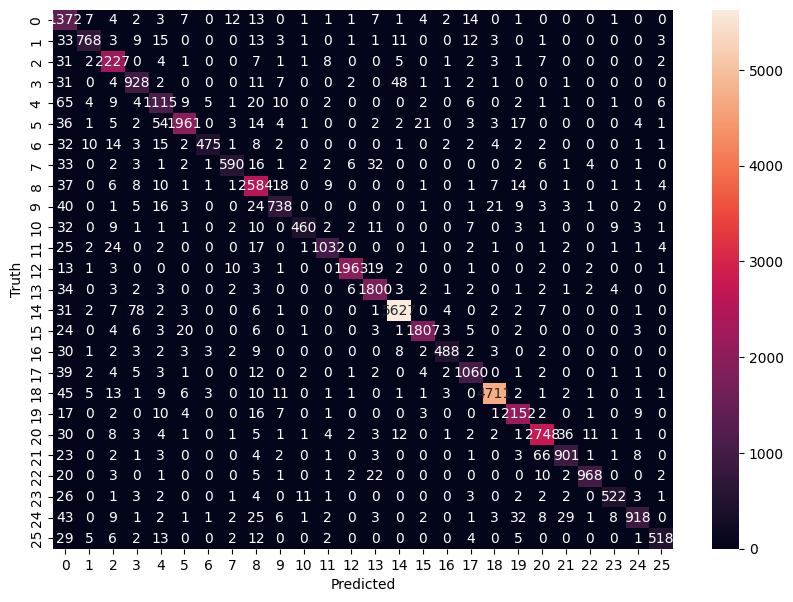

In [91]:
# Matrice de confusion
cm_Maj = tf.math.confusion_matrix(labels=y_test_Maj_2, predictions=y_predicted_labels_Maj)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Maj, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Min (NN)
---

Modèle ...

In [92]:
model_get_min = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_min.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
model_get_min.fit(
    X_train_Min, 
    y_train_Min_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_Min, 
        y_validation_Min_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9293
# loss : 0.2193
# Temps : 2m 45.3s

# Batch 64
# accuracy : 0.9328
# loss : 0.2042
# Temps : 2m 2.7s

# Batch 128
# accuracy : 0.9332
# loss : 0.2038
# Temps : 58.4s

# Batch 256
# accuracy : 0.9338
# loss : 0.2036
# Temps : 38.3s

Epoch 1/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7839 - loss: 0.7886 - val_accuracy: 0.8768 - val_loss: 0.4368
Epoch 2/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8858 - loss: 0.3818 - val_accuracy: 0.8886 - val_loss: 0.3738
Epoch 3/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9000 - loss: 0.3316 - val_accuracy: 0.8975 - val_loss: 0.3498
Epoch 4/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9088 - loss: 0.2980 - val_accuracy: 0.9003 - val_loss: 0.3418
Epoch 5/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9134 - loss: 0.2805 - val_accuracy: 0.8989 - val_loss: 0.3525
Epoch 6/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9174 - loss: 0.2623 - val_accuracy: 0.9026 - val_loss: 0.3451
Epoch 7/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9198 - loss: 0.2558 - val_accuracy: 0.8991 - val_loss: 0.3420
Epoch 8/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9237 - loss: 0.2396 - 

In [94]:
test_loss_min, test_acc_min = model_get_min.evaluate(X_test_Min, y_test_Min_2)
print(f"Test accuracy : {test_acc_min}") # Test accuracy : 
print(f"Test loss : {test_loss_min}") # Test loss : 
# Temps : 

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.9024 - loss: 0.3700
Test accuracy : 0.9033941626548767
Test loss : 0.3659036457538605


In [95]:
# Sauvegarder le modèle
model_get_min.save("../models/Get_Min_v" + ADD_NOM + ".keras")  # Format keras (.keras)

In [96]:
y_predicted_Min = model_get_min.predict(X_test_Min)
y_predicted_Min[1]

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step


array([1.8362544e-01, 3.7345260e-02, 8.6460876e-01, 1.8699969e-03,
       9.9999791e-01, 2.4166969e-03, 6.7377436e-01, 1.0048649e-06,
       6.2216382e-02, 1.8755896e-05, 4.9196376e-07, 6.4702022e-01,
       7.6307618e-09, 9.8259347e-03, 4.4901404e-04, 3.1919930e-02,
       1.6479190e-02, 1.3543236e-03, 1.5705243e-02, 1.5193613e-01,
       8.7691780e-07, 4.0153960e-09, 4.3812047e-06, 1.6507000e-08,
       2.2003452e-07, 2.1533519e-05], dtype=float32)

In [97]:
# y_predicted_labels_Min = [correspondance_Min[np.argmax(i)] for i in y_predicted_Min]
y_predicted_labels_Min = [np.argmax(i) for i in y_predicted_Min]
y_predicted_labels_Min[:5]

[19, 4, 13, 19, 19]

Text(95.72222222222221, 0.5, 'Truth')

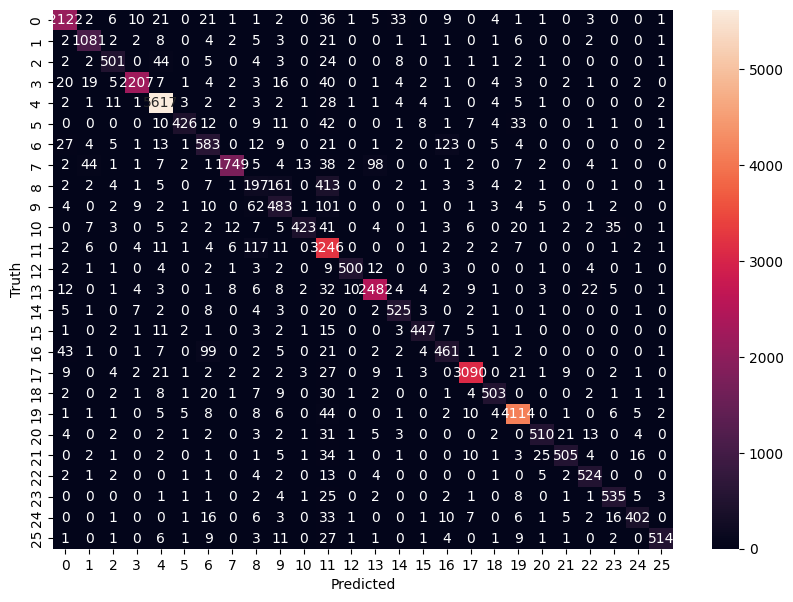

In [98]:
# Matrice de confusion
cm_Min = tf.math.confusion_matrix(labels=y_test_Min_2, predictions=y_predicted_labels_Min)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Min, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Nbr (NN)
---

Modèle ...

In [99]:
model_get_nbr = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid') # output layer : 10 neurones (0-9)
])

model_get_nbr.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [100]:
model_get_nbr.fit(
    X_train_Nbr, 
    y_train_Nbr_2, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(
        X_validation_Nbr, 
        y_validation_Nbr_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9325
# loss : 0.1897
# Temps : 6m 16.0s

# Batch 64
# accuracy : 0.9347
# loss : 0.1844
# Temps : 4m 16.6s

# Batch 128
# accuracy : 0.9343
# loss : 0.1834
# Temps : 1m 59.6s

# Batch 256
# accuracy : 0.9342
# loss : 0.1825
# Temps : 1m 16.2s

Epoch 1/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8836 - loss: 0.3714 - val_accuracy: 0.9171 - val_loss: 0.2597
Epoch 2/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9216 - loss: 0.2342 - val_accuracy: 0.9244 - val_loss: 0.2247
Epoch 3/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9261 - loss: 0.2176 - val_accuracy: 0.9262 - val_loss: 0.2203
Epoch 4/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9274 - loss: 0.2110 - val_accuracy: 0.9241 - val_loss: 0.2296
Epoch 5/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9286 - loss: 0.2066 - val_accuracy: 0.9276 - val_loss: 0.2137
Epoch 6/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9302 - loss: 0.2011 - val_accuracy: 0.9253 - val_loss: 0.2345
Epoch 7/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9314 - loss: 0.1988 - val_accuracy: 0.9272 - val_loss: 0.2212
Epoch 8/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9307 - loss: 0

In [101]:
test_loss_nbr, test_acc_nbr = model_get_nbr.evaluate(X_test_Nbr, y_test_Nbr_2)
print(f"Test accuracy : {test_acc_nbr}") # Test accuracy : 
print(f"Test loss : {test_loss_nbr}") # Test loss : 
# Temps : 3.0s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step - accuracy: 0.9267 - loss: 0.2201
Test accuracy : 0.9275696277618408
Test loss : 0.22041316330432892


In [102]:
# Sauvegarder le modèle
model_get_nbr.save("../models/Get_Nbr_v" + ADD_NOM + ".keras")  # Format keras (.keras)

In [103]:
y_predicted_Nbr = model_get_nbr.predict(X_test_Nbr)
y_predicted_Nbr[1]
# Temps : 3.4s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step


array([4.2407509e-15, 9.6620965e-07, 1.1508823e-07, 1.2475340e-02,
       3.0231320e-06, 1.8907173e-07, 9.0949676e-16, 1.0000000e+00,
       1.2625843e-10, 8.3143283e-07], dtype=float32)

In [104]:
# y_predicted_labels_Nbr = [correspondance_Nbr[np.argmax(i)] for i in y_predicted_Nbr]
y_predicted_labels_Nbr = [np.argmax(i) for i in y_predicted_Nbr]
y_predicted_labels_Nbr[:5]

[1, 7, 0, 9, 3]

Text(95.72222222222221, 0.5, 'Truth')

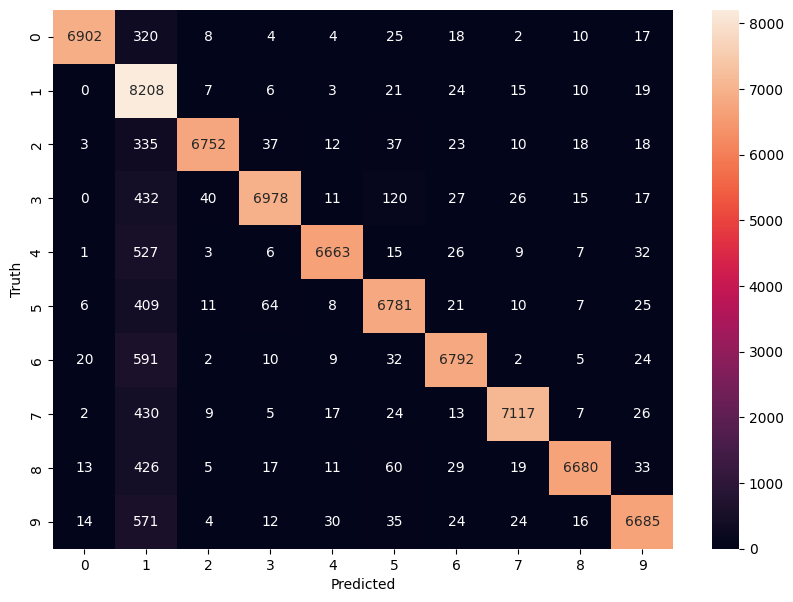

In [105]:
# Matrice de confusion
cm_Nbr = tf.math.confusion_matrix(labels=y_test_Nbr_2, predictions=y_predicted_labels_Nbr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Nbr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')